In [7]:
import random
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.decomposition import PCA
import warnings

from torch.utils.tensorboard import SummaryWriter

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [8]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [9]:
SEED = 1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cuda


In [10]:
## Data Acquisition
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

In [11]:
def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

In [12]:
def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"
ratings = get_ratings_from_csv()
print(ratings)
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)
# films = get_data_from_csv(f"{root}/{ratings}")[]

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5
25000092  162541    56176     2.0
25000093  162541    58559     4.0
25000094  162541    63876     5.0

[25000095 rows x 3 columns]
Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 colum

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
           

class TabNet:
    def __init__(self, ratings, relevance, seed=42,width_values = 8, steps = 3, learning_rate = 2e-2):
        self.aug = RegressionSMOTE(p=0.2)
        #! df['rating'] = df['rating'].astype('float16')

        # Reduce genome-score size


        self.train_loss_history = []
        self.val_loss_history = []

        # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        ratings = None  
        train = X
        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state = seed).reset_index(drop=True)
        
        if "Set" not in train.columns:
            train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

        features = [ col for col in train.columns if col not in ["rating", "Set"]]
        target = "rating"
        
        train_indices = train[train.Set=="train"].index
        valid_indices = train[train.Set=="valid"].index
        test_indices = train[train.Set=="test"].index

        self.X_train = train[features].values[train_indices]
        self.y_train = train[target].values[train_indices].reshape(-1, 1)

        self.X_valid = train[features].values[valid_indices]
        self.y_valid = train[target].values[valid_indices].reshape(-1, 1)

        self.X_test = train[features].values[test_indices]
        self.y_test = train[target].values[test_indices].reshape(-1, 1)

        # pca = PCA()
        # pca.fit(self.X_train)
        # self.X_train = pca.transform(self.X_train)
        # self.X_test = pca.transform(self.X_test)
        # self.X_valid = pca.transform(self.X_valid)
        
        if torch.cuda.is_available():
            self.model = TabNetRegressor(n_d = width_values, 
                                         n_a = width_values , 
                                         n_steps = steps, 
                                         optimizer_params = 
                                         dict(lr=learning_rate), 
                                         seed=seed,  
                                         verbose=0, 
                                         device_name="cuda")  
        else:
            self.model = TabNetRegressor(n_d = width_values, n_a = width_values , n_steps = steps, optimizer_params = dict(lr=learning_rate), seed=seed, verbose=0)  



    def train(self,max_epochs = 150,batchsize = 1024):
        self.model.fit(
            X_train=self.X_train, y_train=self.y_train,
            eval_set=[(self.X_train,self.y_train), (self.X_valid, self.y_valid)],
            eval_name=['train', 'valid'],
            eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
            max_epochs=max_epochs,
            patience=20,
            batch_size=batchsize, virtual_batch_size=1024,
            num_workers=0,
            drop_last=False,
            augmentations=self.aug, #aug,
        ) 

        return self.model.history

    def test(self):
        # Predict the labels of the test set: y_pred
        y_pred = self.model.predict(self.X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        print("=====================================")
        return r2,self.model
    
    def load(self,model):
        self.model =TabNetRegressor()
        self.model.load_model(model)
    
    def save(self,root,name):
        self.model.save_model(f"{root}/{name}.pt")


In [14]:
model = TabNet(ratings, genome_scores)

In [15]:
import itertools

history = None

batchsize = [512,1024,2048]
width = [8,16,32]
steps = [3,5,7]
learning_rate = [2e-2,1e-2]
max_epochs = [70,120,150,210]

best_model_params = None 
best_r2 = 0

total_iterations = len(batchsize) * len(width) * len(steps) * len(learning_rate) * len(max_epochs)
current_iteration = 0

for batchsize,width,steps,learning_rate,max_epochs in itertools.product(batchsize,width,steps,learning_rate,max_epochs):
    current_iteration += 1
    print(f"[{current_iteration}/{total_iterations}] START => batchsize: {batchsize} width: {width} steps: {steps} learning_rate: {learning_rate} max_epochs: {max_epochs}")
    log_name = f'TabNet_{batchsize}_{width}_{steps}_{learning_rate}_{max_epochs}'


    writer = SummaryWriter('run/'+log_name)
    model = TabNet(ratings, genome_scores,width_values = width, steps = steps, learning_rate = learning_rate)
    history = model.train(max_epochs = max_epochs,batchsize = batchsize)
    r2score, instance = model.test()
    writer.add_hparams({'batchsize': batchsize, 'hidden_size1': width, 'hidden_size2': steps, 'lr': learning_rate, 'num_epochs': max_epochs}, {'metrics/r2': r2score})
    
    if r2score > best_r2:
        best_r2 = r2score
        best_model_params = f'{batchsize}_{width}_{steps}_{learning_rate}_{max_epochs}'
        model.save("model",best_model_params)
        print(f"New best model: {best_model_params} with r2: {best_r2}")

    writer.flush()
writer.close()
model = TabNet(ratings,genome_scores)
print(f'Best model SCORE: {best_r2}')
model.load(f"model/{best_model_params}.pt.zip")
print(model.test())



[1/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.00898


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008375112472055 RMSE: 0.09151564058703299 R2: 0.9629266041726134 MAE: 0.07119005210035172
Successfully saved model at model/512_8_3_0.02_70.pt.zip
New best model: 512_8_3_0.02_70 with r2: 0.9629266041726134
[2/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 112 and best_valid_mse = 0.00727


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007141037128486071 RMSE: 0.08450465743665299 R2: 0.9683893802064406 MAE: 0.064916241985196
Successfully saved model at model/512_8_3_0.02_120.pt.zip
New best model: 512_8_3_0.02_120 with r2: 0.9683893802064406
[3/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_mse = 0.00727


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007141037128486071 RMSE: 0.08450465743665299 R2: 0.9683893802064406 MAE: 0.064916241985196
[4/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_mse = 0.00727


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007141037128486071 RMSE: 0.08450465743665299 R2: 0.9683893802064406 MAE: 0.064916241985196
[5/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 66 and best_valid_mse = 0.01092


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011819705597407698 RMSE: 0.1087184694401448 R2: 0.9476787176723906 MAE: 0.08514873473634856
[6/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 116 and best_valid_mse = 0.00795


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008138680034445466 RMSE: 0.09021463315031251 R2: 0.963973199472101 MAE: 0.06987249606534694
[7/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 146 with best_epoch = 126 and best_valid_mse = 0.00778


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007943909841135579 RMSE: 0.08912861404249244 R2: 0.9648353720693106 MAE: 0.06908251466365427
[8/216] START => batchsize: 512 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 146 with best_epoch = 126 and best_valid_mse = 0.00778


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007943909841135579 RMSE: 0.08912861404249244 R2: 0.9648353720693106 MAE: 0.06908251466365427
[9/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.00818


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008558012322190566 RMSE: 0.09250952557542691 R2: 0.9621169770107729 MAE: 0.07158280800057475
[10/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007134889267118613 RMSE: 0.08446827373113892 R2: 0.9684165944198292 MAE: 0.06500316417632032
Successfully saved model at model/512_8_5_0.02_120.pt.zip
New best model: 512_8_5_0.02_120 with r2: 0.9684165944198292
[11/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007134889267118613 RMSE: 0.08446827373113892 R2: 0.9684165944198292 MAE: 0.06500316417632032
[12/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007134889267118613 RMSE: 0.08446827373113892 R2: 0.9684165944198292 MAE: 0.06500316417632032
[13/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 63 and best_valid_mse = 0.01412


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016109342887157978 RMSE: 0.12692258619787883 R2: 0.9286901462675927 MAE: 0.0972695573526162
[14/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.00798


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009108853428546749 RMSE: 0.09544031343487273 R2: 0.9596786156822441 MAE: 0.07317697138838591
[15/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 140 and best_valid_mse = 0.00717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00822872809439037 RMSE: 0.09071233705726234 R2: 0.963574591407915 MAE: 0.06924833909929502
[16/216] START => batchsize: 512 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 160 with best_epoch = 140 and best_valid_mse = 0.00717


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00822872809439037 RMSE: 0.09071233705726234 R2: 0.963574591407915 MAE: 0.06924833909929502
[17/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.01289


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.015866123772218528 RMSE: 0.1259608025229219 R2: 0.929766783572587 MAE: 0.09725992859282552
[18/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 113 with best_epoch = 93 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009278571397335723 RMSE: 0.0963253414078337 R2: 0.9589273396299012 MAE: 0.07514834659452889
[19/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 113 with best_epoch = 93 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009278571397335723 RMSE: 0.0963253414078337 R2: 0.9589273396299012 MAE: 0.07514834659452889
[20/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 113 with best_epoch = 93 and best_valid_mse = 0.00834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009278571397335723 RMSE: 0.0963253414078337 R2: 0.9589273396299012 MAE: 0.07514834659452889
[21/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.02622


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02663869960772536 RMSE: 0.16321366244198235 R2: 0.8820807412223653 MAE: 0.12632981284162598
[22/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 104 and best_valid_mse = 0.01322


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013623766295144592 RMSE: 0.11672089056867495 R2: 0.9396928361016063 MAE: 0.09133227029187603
[23/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 124 with best_epoch = 104 and best_valid_mse = 0.01322


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013623766295144592 RMSE: 0.11672089056867495 R2: 0.9396928361016063 MAE: 0.09133227029187603
[24/216] START => batchsize: 512 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 124 with best_epoch = 104 and best_valid_mse = 0.01322


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013623766295144592 RMSE: 0.11672089056867495 R2: 0.9396928361016063 MAE: 0.09133227029187603
[25/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 55 and best_valid_mse = 0.00805


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008647970421262686 RMSE: 0.09299446446570186 R2: 0.9617187671687071 MAE: 0.0723402907145758
[26/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.00805


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008647970421262686 RMSE: 0.09299446446570186 R2: 0.9617187671687071 MAE: 0.0723402907145758
[27/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.00805


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008647970421262686 RMSE: 0.09299446446570186 R2: 0.9617187671687071 MAE: 0.0723402907145758
[28/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_mse = 0.00805


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008647970421262686 RMSE: 0.09299446446570186 R2: 0.9617187671687071 MAE: 0.0723402907145758
[29/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.01055


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012659221029222591 RMSE: 0.11251320379947675 R2: 0.9439625063366358 MAE: 0.08604329448006395
[30/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 106 and best_valid_mse = 0.00791


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009565823222873627 RMSE: 0.09780502657263392 R2: 0.9576557864817088 MAE: 0.07502581652147858
[31/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 126 with best_epoch = 106 and best_valid_mse = 0.00791


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009565823222873627 RMSE: 0.09780502657263392 R2: 0.9576557864817088 MAE: 0.07502581652147858
[32/216] START => batchsize: 512 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 126 with best_epoch = 106 and best_valid_mse = 0.00791


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009565823222873627 RMSE: 0.09780502657263392 R2: 0.9576557864817088 MAE: 0.07502581652147858
[33/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.01143


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011728217246775918 RMSE: 0.10829689398489653 R2: 0.9480837013484766 MAE: 0.08467057999171625
[34/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007549762483588407 RMSE: 0.08688936922079943 R2: 0.9665801105488738 MAE: 0.06660373809016729
[35/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007549762483588407 RMSE: 0.08688936922079943 R2: 0.9665801105488738 MAE: 0.06660373809016729
[36/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 133 with best_epoch = 113 and best_valid_mse = 0.00673


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007549762483588407 RMSE: 0.08688936922079943 R2: 0.9665801105488738 MAE: 0.06660373809016729
[37/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.02021


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02198564776118744 RMSE: 0.14827558046147532 R2: 0.9026780088396831 MAE: 0.11326929337090523
[38/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.01676


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01735769241558445 RMSE: 0.13174859549757809 R2: 0.9231641839175099 MAE: 0.1017932363163558
[39/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.01676


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01735769241558445 RMSE: 0.13174859549757809 R2: 0.9231641839175099 MAE: 0.1017932363163558
[40/216] START => batchsize: 512 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.01676


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01735769241558445 RMSE: 0.13174859549757809 R2: 0.9231641839175099 MAE: 0.1017932363163558
[41/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.01682


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.017634763614599785 RMSE: 0.1327959472822864 R2: 0.9219376964801484 MAE: 0.1005154764386585
[42/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.00858


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008656045050909248 RMSE: 0.09303786890782295 R2: 0.9616830238945666 MAE: 0.07288296679932475
[43/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 144 with best_epoch = 124 and best_valid_mse = 0.00721


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0073010252065119855 RMSE: 0.08544603680986021 R2: 0.9676811746313981 MAE: 0.06584019803249924
[44/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 144 with best_epoch = 124 and best_valid_mse = 0.00721


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0073010252065119855 RMSE: 0.08544603680986021 R2: 0.9676811746313981 MAE: 0.06584019803249924
[45/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.02767


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.028170894250910218 RMSE: 0.16784187275799273 R2: 0.8752983059200421 MAE: 0.12942559460707914
[46/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 116 and best_valid_mse = 0.00985


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010791597660126176 RMSE: 0.10388261481174882 R2: 0.9522297553616509 MAE: 0.07900345731809026
[47/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.00794


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008551167299655413 RMSE: 0.09247252186274263 R2: 0.9621472772880216 MAE: 0.07111861183812761
[48/216] START => batchsize: 512 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 194 with best_epoch = 174 and best_valid_mse = 0.00703


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007767138002495911 RMSE: 0.08813136786919804 R2: 0.9656178728854955 MAE: 0.06724462350560771
[49/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 57 and best_valid_mse = 0.00812


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008583657804481162 RMSE: 0.09264803184353762 R2: 0.9620034543423531 MAE: 0.07248430750330484
[50/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.00706


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007626782981279661 RMSE: 0.08733145470722253 R2: 0.9662391704830231 MAE: 0.0669989335259039
[51/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.00706


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007626782981279661 RMSE: 0.08733145470722253 R2: 0.9662391704830231 MAE: 0.0669989335259039
[52/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 94 with best_epoch = 74 and best_valid_mse = 0.00706


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007626782981279661 RMSE: 0.08733145470722253 R2: 0.9662391704830231 MAE: 0.0669989335259039
[53/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.01398


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014058218174627652 RMSE: 0.11856735712086885 R2: 0.9377696850335137 MAE: 0.09152624288609543
[54/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 114 and best_valid_mse = 0.00854


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008434985775528236 RMSE: 0.09184217863012743 R2: 0.9626615681284334 MAE: 0.07048662990423411
[55/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 134 with best_epoch = 114 and best_valid_mse = 0.00854


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008434985775528236 RMSE: 0.09184217863012743 R2: 0.9626615681284334 MAE: 0.07048662990423411
[56/216] START => batchsize: 512 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 134 with best_epoch = 114 and best_valid_mse = 0.00854


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008434985775528236 RMSE: 0.09184217863012743 R2: 0.9626615681284334 MAE: 0.07048662990423411
[57/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_mse = 0.009


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010189981961128572 RMSE: 0.10094544051678893 R2: 0.9548928762474096 MAE: 0.07836096113731149
[58/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 104 with best_epoch = 84 and best_valid_mse = 0.00766


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008717751900092137 RMSE: 0.093368902211026 R2: 0.9614098714500291 MAE: 0.0719504365574335
[59/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 104 with best_epoch = 84 and best_valid_mse = 0.00766


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008717751900092137 RMSE: 0.093368902211026 R2: 0.9614098714500291 MAE: 0.0719504365574335
[60/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 104 with best_epoch = 84 and best_valid_mse = 0.00766


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008717751900092137 RMSE: 0.093368902211026 R2: 0.9614098714500291 MAE: 0.0719504365574335
[61/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.01846


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.018030326921231014 RMSE: 0.13427705284683236 R2: 0.9201866901395815 MAE: 0.10480189396302236
[62/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 110 and best_valid_mse = 0.00962


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010317578492272595 RMSE: 0.10157548174767667 R2: 0.9543280555693485 MAE: 0.07908120993278969
[63/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 142 and best_valid_mse = 0.00826


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008657098758644984 RMSE: 0.09304353152500706 R2: 0.9616783595364337 MAE: 0.07135108432468051
[64/216] START => batchsize: 512 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 201 with best_epoch = 181 and best_valid_mse = 0.00642


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.006612335665050214 RMSE: 0.08131626937489332 R2: 0.9707297378665768 MAE: 0.06346850942509422
Successfully saved model at model/512_32_5_0.01_210.pt.zip
New best model: 512_32_5_0.01_210 with r2: 0.9707297378665768
[65/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 53 and best_valid_mse = 0.01089


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010311334675286728 RMSE: 0.10154474223359242 R2: 0.9543556945412863 MAE: 0.07957523635350915
[66/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_mse = 0.01089


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010311334675286728 RMSE: 0.10154474223359242 R2: 0.9543556945412863 MAE: 0.07957523635350915
[67/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_mse = 0.01089


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010311334675286728 RMSE: 0.10154474223359242 R2: 0.9543556945412863 MAE: 0.07957523635350915
[68/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_mse = 0.01089


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010311334675286728 RMSE: 0.10154474223359242 R2: 0.9543556945412863 MAE: 0.07957523635350915
[69/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.02821


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02852075762547459 RMSE: 0.1688808977518612 R2: 0.8737495955697026 MAE: 0.13185311188403784
[70/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 106 and best_valid_mse = 0.01289


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01265242483558254 RMSE: 0.1124829979845067 R2: 0.9439925904671806 MAE: 0.08714293149984562
[71/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.0086


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010527390654537743 RMSE: 0.10260307331916399 R2: 0.953399297971524 MAE: 0.07461142456596287
[72/216] START => batchsize: 512 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 181 with best_epoch = 161 and best_valid_mse = 0.00746


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007798787875814569 RMSE: 0.08831074609476793 R2: 0.9654777710915978 MAE: 0.06845275130375078
[73/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.00984


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011622210137648777 RMSE: 0.10780635481106286 R2: 0.9485529539740744 MAE: 0.07918314045083846
[74/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 105 and best_valid_mse = 0.00867


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009875612527464245 RMSE: 0.09937611648411425 R2: 0.9562844685978594 MAE: 0.07677445818204054
[75/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 142 with best_epoch = 122 and best_valid_mse = 0.00849


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009241560466106897 RMSE: 0.0961330352485913 R2: 0.9590911727614518 MAE: 0.07373088380949672
[76/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 142 with best_epoch = 122 and best_valid_mse = 0.00849


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009241560466106897 RMSE: 0.0961330352485913 R2: 0.9590911727614518 MAE: 0.07373088380949672
[77/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.0161


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.017687417889978966 RMSE: 0.1329940520849672 R2: 0.9217046162917152 MAE: 0.10268828132515247
[78/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.01098


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012074888754559787 RMSE: 0.10988579869373379 R2: 0.9465491201624887 MAE: 0.0854801873071521
[79/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.00933


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010154190684123042 RMSE: 0.10076800426783812 R2: 0.9550513104396693 MAE: 0.07840252072567427
[80/216] START => batchsize: 1024 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 200 and best_valid_mse = 0.00781


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009122723252845999 RMSE: 0.09551294809001551 R2: 0.9596172193143722 MAE: 0.07356143214590999
[81/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 57 and best_valid_mse = 0.02142


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021867342091138563 RMSE: 0.14787610385433667 R2: 0.9032017024556173 MAE: 0.11562706844187325
[82/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.0093


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010789114385916003 RMSE: 0.10387066181514394 R2: 0.9522407478597277 MAE: 0.08168654386534051
[83/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.00766


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008824375481557381 RMSE: 0.09393814710519567 R2: 0.9609378899389289 MAE: 0.07310606435466165
[84/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 180 with best_epoch = 160 and best_valid_mse = 0.00713


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008503297348262814 RMSE: 0.09221332522072292 R2: 0.9623591791176552 MAE: 0.07136311903686834
[85/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.02467


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.026391994900956065 RMSE: 0.16245613223561634 R2: 0.8831728078993271 MAE: 0.12486284737274042
[86/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_mse = 0.02246


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.025655173469957767 RMSE: 0.1601723242946726 R2: 0.8864344324633728 MAE: 0.12301658799611564
[87/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_mse = 0.02246


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.025655173469957767 RMSE: 0.1601723242946726 R2: 0.8864344324633728 MAE: 0.12301658799611564
[88/216] START => batchsize: 1024 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_mse = 0.02246


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.025655173469957767 RMSE: 0.1601723242946726 R2: 0.8864344324633728 MAE: 0.12301658799611564
[89/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 64 and best_valid_mse = 0.03534


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03440064090789094 RMSE: 0.1854740976737478 R2: 0.8477216179066913 MAE: 0.14315428522491794
[90/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.01119


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01170717887502426 RMSE: 0.108199717536712 R2: 0.9481768301137459 MAE: 0.08445318955064202
[91/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 133 and best_valid_mse = 0.00876


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009789056496205605 RMSE: 0.09893966088584297 R2: 0.9566676187965949 MAE: 0.07639472616605016
[92/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 153 with best_epoch = 133 and best_valid_mse = 0.00876


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009789056496205605 RMSE: 0.09893966088584297 R2: 0.9566676187965949 MAE: 0.07639472616605016
[93/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.03444


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03402042042020673 RMSE: 0.18444625347294732 R2: 0.8494047074996529 MAE: 0.14220069162230795
[94/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 102 and best_valid_mse = 0.02836


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.028690767318405874 RMSE: 0.1693834918709786 R2: 0.8729970281669883 MAE: 0.13000789111154232
[95/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 139 and best_valid_mse = 0.02303


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021756850272302036 RMSE: 0.14750203480732743 R2: 0.9036908071630565 MAE: 0.11580096166199103
[96/216] START => batchsize: 1024 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 206 and best_valid_mse = 0.01456


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014261643606721613 RMSE: 0.11942212360664842 R2: 0.9368691990292313 MAE: 0.09184155490074283
[97/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.01163


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012593156980683579 RMSE: 0.11221923623284726 R2: 0.9442549464238129 MAE: 0.08673665014063123
[98/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 105 with best_epoch = 85 and best_valid_mse = 0.00951


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010208465452036438 RMSE: 0.10103695092408736 R2: 0.9548110569551929 MAE: 0.07708228677870457
[99/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 105 with best_epoch = 85 and best_valid_mse = 0.00951


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010208465452036438 RMSE: 0.10103695092408736 R2: 0.9548110569551929 MAE: 0.07708228677870457
[100/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 105 with best_epoch = 85 and best_valid_mse = 0.00951


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010208465452036438 RMSE: 0.10103695092408736 R2: 0.9548110569551929 MAE: 0.07708228677870457
[101/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.02407


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02361152188380732 RMSE: 0.15366041091903704 R2: 0.8954808905783445 MAE: 0.1199640090960818
[102/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.01382


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013986024633472656 RMSE: 0.11826252421402418 R2: 0.9380892580226945 MAE: 0.09256322246229669
[103/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 144 and best_valid_mse = 0.01183


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012684101958267673 RMSE: 0.1126237184533865 R2: 0.9438523680508373 MAE: 0.0872954752981479
[104/216] START => batchsize: 1024 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 190 and best_valid_mse = 0.00973


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010819029369025276 RMSE: 0.1040145632545043 R2: 0.9521083257563016 MAE: 0.0799307262576551
[105/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.03453


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.037162012855821436 RMSE: 0.19277451298297044 R2: 0.8354980883011063 MAE: 0.14586767394588587
[106/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.01198


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012229149411796926 RMSE: 0.11058548463427254 R2: 0.9458662676723966 MAE: 0.0862227680042081
[107/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 137 with best_epoch = 117 and best_valid_mse = 0.01198


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012229149411796926 RMSE: 0.11058548463427254 R2: 0.9458662676723966 MAE: 0.0862227680042081
[108/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 137 with best_epoch = 117 and best_valid_mse = 0.01198


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012229149411796926 RMSE: 0.11058548463427254 R2: 0.9458662676723966 MAE: 0.0862227680042081
[109/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.02569


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02848147850136505 RMSE: 0.16876456530138384 R2: 0.8739234691171593 MAE: 0.12919991373026074
[110/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 102 and best_valid_mse = 0.02065


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021383570062010113 RMSE: 0.14623122122860807 R2: 0.9053431748222202 MAE: 0.11478096877611922
[111/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 122 with best_epoch = 102 and best_valid_mse = 0.02065


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021383570062010113 RMSE: 0.14623122122860807 R2: 0.9053431748222202 MAE: 0.11478096877611922
[112/216] START => batchsize: 1024 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 122 with best_epoch = 102 and best_valid_mse = 0.02065


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021383570062010113 RMSE: 0.14623122122860807 R2: 0.9053431748222202 MAE: 0.11478096877611922
[113/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.02871


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02913117571377433 RMSE: 0.1706785742668784 R2: 0.8710475098982273 MAE: 0.13315613724781766
[114/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 112 and best_valid_mse = 0.02184


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02205696210976013 RMSE: 0.14851586484197615 R2: 0.902362327697295 MAE: 0.1172270965919984
[115/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_mse = 0.02184


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02205696210976013 RMSE: 0.14851586484197615 R2: 0.902362327697295 MAE: 0.1172270965919984
[116/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_mse = 0.02184


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02205696210976013 RMSE: 0.14851586484197615 R2: 0.902362327697295 MAE: 0.1172270965919984
[117/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_mse = 0.03428


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0350619874534745 RMSE: 0.18724846448896315 R2: 0.8447940915785013 MAE: 0.14483013092895322
[118/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 113 and best_valid_mse = 0.02579


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.023830028113339525 RMSE: 0.15436977720181994 R2: 0.8945136476947143 MAE: 0.1215037776431553
[119/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_mse = 0.02196


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022046572683668587 RMSE: 0.14848088322632172 R2: 0.9024083176833634 MAE: 0.11671216213316794
[120/216] START => batchsize: 1024 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 209 and best_valid_mse = 0.01399


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014118470005917231 RMSE: 0.11882116817266708 R2: 0.9375029733925445 MAE: 0.09390490996478155
[121/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.01168


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013231213670586344 RMSE: 0.11502701278650308 R2: 0.9414305153127078 MAE: 0.08837258046907047
[122/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 108 with best_epoch = 88 and best_valid_mse = 0.00983


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010982032237949984 RMSE: 0.10479519186465562 R2: 0.951386774863605 MAE: 0.08012447807147817
[123/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 108 with best_epoch = 88 and best_valid_mse = 0.00983


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010982032237949984 RMSE: 0.10479519186465562 R2: 0.951386774863605 MAE: 0.08012447807147817
[124/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 108 with best_epoch = 88 and best_valid_mse = 0.00983


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010982032237949984 RMSE: 0.10479519186465562 R2: 0.951386774863605 MAE: 0.08012447807147817
[125/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.01484


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016797607113182872 RMSE: 0.12960558287814175 R2: 0.9256434657399711 MAE: 0.09753317090168223
[126/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 114 and best_valid_mse = 0.01076


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.012555736827355873 RMSE: 0.11205238430018288 R2: 0.9444205910239145 MAE: 0.08400504967873651
[127/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 133 and best_valid_mse = 0.01007


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011144089059904045 RMSE: 0.10556556758670908 R2: 0.950669411756318 MAE: 0.0793923232805667
[128/216] START => batchsize: 1024 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 153 with best_epoch = 133 and best_valid_mse = 0.01007


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011144089059904045 RMSE: 0.10556556758670908 R2: 0.950669411756318 MAE: 0.0793923232805667
[129/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.02445


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022304647797904475 RMSE: 0.1493474063983184 R2: 0.9012659185937762 MAE: 0.11562770358514915
[130/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.00956


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009894927898657313 RMSE: 0.09947325217694108 R2: 0.9561989668921591 MAE: 0.07682242366835725
[131/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 133 and best_valid_mse = 0.00858


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008609746380974316 RMSE: 0.09278871903940865 R2: 0.961887970266631 MAE: 0.07195077009615775
[132/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 153 with best_epoch = 133 and best_valid_mse = 0.00858


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008609746380974316 RMSE: 0.09278871903940865 R2: 0.961887970266631 MAE: 0.07195077009615775
[133/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 64 and best_valid_mse = 0.02459


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.023601290263645564 RMSE: 0.1536271143504478 R2: 0.8955261820183673 MAE: 0.12131727959445024
[134/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.01847


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02062917473229941 RMSE: 0.14362859998029434 R2: 0.9086825922643162 MAE: 0.10969209936711113
[135/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 145 with best_epoch = 125 and best_valid_mse = 0.01738


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01935961132484711 RMSE: 0.13913882033727004 R2: 0.9143024602827449 MAE: 0.10583662678445929
[136/216] START => batchsize: 1024 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 145 with best_epoch = 125 and best_valid_mse = 0.01738


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01935961132484711 RMSE: 0.13913882033727004 R2: 0.9143024602827449 MAE: 0.10583662678445929
[137/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.03578


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03694351132351565 RMSE: 0.19220694920713885 R2: 0.836465310391925 MAE: 0.14850222205758573
[138/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120

Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 0.02811


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.026471739716628844 RMSE: 0.1627013820366282 R2: 0.8828198083275024 MAE: 0.12606350207318956
[139/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150

Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 0.02811


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.026471739716628844 RMSE: 0.1627013820366282 R2: 0.8828198083275024 MAE: 0.12606350207318956
[140/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 0.02811


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.026471739716628844 RMSE: 0.1627013820366282 R2: 0.8828198083275024 MAE: 0.12606350207318956
[141/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.03478


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.037760669213400995 RMSE: 0.19432104675871062 R2: 0.832848067279516 MAE: 0.1496782424967345
[142/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.03478


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.037760669213400995 RMSE: 0.19432104675871062 R2: 0.832848067279516 MAE: 0.1496782424967345
[143/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.03478


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.037760669213400995 RMSE: 0.19432104675871062 R2: 0.832848067279516 MAE: 0.1496782424967345
[144/216] START => batchsize: 1024 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_mse = 0.03478


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.037760669213400995 RMSE: 0.19432104675871062 R2: 0.832848067279516 MAE: 0.1496782424967345
[145/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.0233


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02395427708844633 RMSE: 0.15477169343405897 R2: 0.8939636453573545 MAE: 0.12396044094449743
[146/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.00872


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.00957516995897943 RMSE: 0.09785279739986706 R2: 0.9576144120824395 MAE: 0.07598936641230457
[147/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 144 and best_valid_mse = 0.00793


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008334083716089211 RMSE: 0.09129120284063087 R2: 0.9631082226661323 MAE: 0.07102421502504455
[148/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 164 with best_epoch = 144 and best_valid_mse = 0.00793


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.008334083716089211 RMSE: 0.09129120284063087 R2: 0.9631082226661323 MAE: 0.07102421502504455
[149/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.03724


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03650514800004029 RMSE: 0.19106320420227513 R2: 0.8384057759154193 MAE: 0.15371554649534505
[150/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.01638


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016872618587778145 RMSE: 0.12989464418434712 R2: 0.9253114188452524 MAE: 0.0995969313481082
[151/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.01407


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013706762240151207 RMSE: 0.117075882401762 R2: 0.9393254450329411 MAE: 0.08922299251962083
[152/216] START => batchsize: 2048 width: 8 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 200 and best_valid_mse = 0.01056


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011769814717027524 RMSE: 0.10848877691737299 R2: 0.9478995653759508 MAE: 0.08129944172682498
[153/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.04491


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04519727456621285 RMSE: 0.21259650647697118 R2: 0.7999290808447933 MAE: 0.1698057028276727
[154/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.01715


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016594637691366033 RMSE: 0.1288201757931033 R2: 0.926541933162466 MAE: 0.10031240820390447
[155/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 139 and best_valid_mse = 0.01427


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013711857077734643 RMSE: 0.11709763907839749 R2: 0.9393028921500949 MAE: 0.0909214038412098
[156/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 206 and best_valid_mse = 0.00813


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.007957497740721953 RMSE: 0.08920480783411819 R2: 0.9647752236735118 MAE: 0.06890399511740031
[157/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.03883


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04000648991332048 RMSE: 0.2000162241252456 R2: 0.8229066843974037 MAE: 0.15371655535763756
[158/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 117 and best_valid_mse = 0.02651


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.028205834084658526 RMSE: 0.16794592607341963 R2: 0.8751436407390053 MAE: 0.13143553825550452
[159/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.02405


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.025554110439573882 RMSE: 0.15985653080050838 R2: 0.8868817995574195 MAE: 0.12634906903847543
[160/216] START => batchsize: 2048 width: 8 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.01851


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.019784943211064814 RMSE: 0.14065896064973896 R2: 0.9124196799107352 MAE: 0.10967189132995135
[161/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 65 and best_valid_mse = 0.07879


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.07697506760292173 RMSE: 0.27744380981186395 R2: 0.659261035645204 MAE: 0.22481702105413884
[162/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.03364


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03305079673856158 RMSE: 0.1817987809050478 R2: 0.853696857924281 MAE: 0.13981453257582094
[163/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.03088


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.029799521386948424 RMSE: 0.17262537874527148 R2: 0.8680890011290878 MAE: 0.13331572041303533
[164/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.01732


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01942429719579797 RMSE: 0.13937107732882734 R2: 0.914016120856713 MAE: 0.10758297533462027
[165/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.06476


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06106956504096897 RMSE: 0.2471225708853179 R2: 0.7296685668013914 MAE: 0.19937506264368068
[166/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.03234


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.029980566639710635 RMSE: 0.17314897238999322 R2: 0.8672875835552083 MAE: 0.13201246305590936
[167/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 137 and best_valid_mse = 0.03098


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.029001326511516767 RMSE: 0.1702977583866469 R2: 0.8716223022833121 MAE: 0.12868894609230358
[168/216] START => batchsize: 2048 width: 8 steps: 7 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 157 with best_epoch = 137 and best_valid_mse = 0.03098


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.029001326511516767 RMSE: 0.1702977583866469 R2: 0.8716223022833121 MAE: 0.12868894609230358
[169/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.02329


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02224361730693282 RMSE: 0.14914294253142796 R2: 0.901536077061126 MAE: 0.12033596044558056
[170/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.00995


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011041300761627156 RMSE: 0.10507759400379872 R2: 0.9511244159465492 MAE: 0.08081405903659018
[171/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 137 and best_valid_mse = 0.00922


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.010153319674260992 RMSE: 0.10076368231789165 R2: 0.9550551660647123 MAE: 0.07856697110268633
[172/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 191 and best_valid_mse = 0.00805


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.009007841415351677 RMSE: 0.09490964869470163 R2: 0.9601257569428537 MAE: 0.07359046048737412
[173/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.03416


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.036600084044667136 RMSE: 0.1913114843512201 R2: 0.8379855306264777 MAE: 0.15426421877231924
[174/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.01849


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01948787676802211 RMSE: 0.13959898555513256 R2: 0.9137346785888669 MAE: 0.10766097020677794
[175/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_mse = 0.01634


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.016572914149714464 RMSE: 0.12873583086970955 R2: 0.9266380949108733 MAE: 0.09881818494559975
[176/216] START => batchsize: 2048 width: 16 steps: 3 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 198 and best_valid_mse = 0.0139


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014777682321918333 RMSE: 0.12156349090873597 R2: 0.9345848944763576 MAE: 0.09301762578823235
[177/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.04047


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03802132985724896 RMSE: 0.19499058915047401 R2: 0.8316942230465888 MAE: 0.15066217910318802
[178/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 114 and best_valid_mse = 0.0188


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.018873009703094724 RMSE: 0.13737907301730756 R2: 0.9164564581655994 MAE: 0.10931320941769745
[179/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.01522


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01438480177998653 RMSE: 0.11993665736540489 R2: 0.9363240252513193 MAE: 0.09485589032834447
[180/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 192 and best_valid_mse = 0.01178


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011272783634574114 RMSE: 0.1061733659378571 R2: 0.9500997304626637 MAE: 0.08303623739349428
[181/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_mse = 0.04219


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04001425817236186 RMSE: 0.2000356422549788 R2: 0.8228722973078819 MAE: 0.1556033037064993
[182/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.02287


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02394955416735661 RMSE: 0.15475643497882927 R2: 0.8939845519091895 MAE: 0.12153345741066031
[183/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 144 and best_valid_mse = 0.01834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.020522259605344106 RMSE: 0.14325592345639362 R2: 0.9091558643349631 MAE: 0.11200275627046535
[184/216] START => batchsize: 2048 width: 16 steps: 5 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 164 with best_epoch = 144 and best_valid_mse = 0.01834


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.020522259605344106 RMSE: 0.14325592345639362 R2: 0.9091558643349631 MAE: 0.11200275627046535
[185/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.06236


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.060704898817594555 RMSE: 0.24638364153813977 R2: 0.7312828036596005 MAE: 0.19739233700311906
[186/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.0324


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.03220998303438931 RMSE: 0.1794713989313877 R2: 0.8574188162115135 MAE: 0.13861582066156267
[187/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 131 and best_valid_mse = 0.02993


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.030815414967625476 RMSE: 0.17554319971911608 R2: 0.8635920316900971 MAE: 0.13703465911625412
[188/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 151 with best_epoch = 131 and best_valid_mse = 0.02993


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.030815414967625476 RMSE: 0.17554319971911608 R2: 0.8635920316900971 MAE: 0.13703465911625412
[189/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.06877


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.06888586448624384 RMSE: 0.26246116757768917 R2: 0.6950688209225215 MAE: 0.21369861745517033
[190/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.0367


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04208281509685664 RMSE: 0.20514096396589504 R2: 0.8137155928565494 MAE: 0.15882896516635897
[191/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 149 and best_valid_mse = 0.03152


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.034285956967484814 RMSE: 0.1851646752690286 R2: 0.8482292795210167 MAE: 0.14689632406781913
[192/216] START => batchsize: 2048 width: 16 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 208 and best_valid_mse = 0.02638


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.027387453835023865 RMSE: 0.16549155215606587 R2: 0.8787662947670266 MAE: 0.129957268591092
[193/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.02711


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.0266129574940405 RMSE: 0.16313478321326969 R2: 0.8821946916407337 MAE: 0.12973152268356963
[194/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 110 and best_valid_mse = 0.01119


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01109871858551169 RMSE: 0.10535045602896881 R2: 0.9508702493643665 MAE: 0.08244154306875834
[195/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 138 and best_valid_mse = 0.01021


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011520020366622684 RMSE: 0.10733135779734962 R2: 0.9490053087147899 MAE: 0.08290066815547784
[196/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 158 with best_epoch = 138 and best_valid_mse = 0.01021


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.011520020366622684 RMSE: 0.10733135779734962 R2: 0.9490053087147899 MAE: 0.08290066815547784
[197/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.04177


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.042161427337623875 RMSE: 0.2053324799870295 R2: 0.8133676067574295 MAE: 0.1634448310550407
[198/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 109 and best_valid_mse = 0.02202


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022901083125030555 RMSE: 0.1513310382077337 R2: 0.8986257292181993 MAE: 0.11740154129105664
[199/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 136 and best_valid_mse = 0.01978


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02018218581748281 RMSE: 0.14206402013698896 R2: 0.9106612399570777 MAE: 0.10926226773160413
[200/216] START => batchsize: 2048 width: 32 steps: 3 learning_rate: 0.01 max_epochs: 210

Early stopping occurred at epoch 172 with best_epoch = 152 and best_valid_mse = 0.01875


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.018940890732262593 RMSE: 0.13762590865190533 R2: 0.9161559750052946 MAE: 0.10690252263606626
[201/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.05197


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05267415633914863 RMSE: 0.2295085103850152 R2: 0.7668318062174347 MAE: 0.18213220431711571
[202/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 115 and best_valid_mse = 0.02153


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02218775425949045 RMSE: 0.14895554457451543 R2: 0.9017833612470836 MAE: 0.1133989031515367
[203/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 147 and best_valid_mse = 0.01508


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.015228189299080762 RMSE: 0.12340254980785755 R2: 0.9325906736771659 MAE: 0.09403953958296495
[204/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.02 max_epochs: 210

Early stopping occurred at epoch 172 with best_epoch = 152 and best_valid_mse = 0.01343


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.014174767631636324 RMSE: 0.11905783313850594 R2: 0.9372537654960069 MAE: 0.09067383464346154
[205/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.04883


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.04980301838625773 RMSE: 0.22316589879786233 R2: 0.779541227632099 MAE: 0.17210115245975585
[206/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 119 and best_valid_mse = 0.02496


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02582528233206318 RMSE: 0.16070246523330992 R2: 0.8856814260769366 MAE: 0.12088472373215618
[207/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 146 and best_valid_mse = 0.02168


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.021193005085485852 RMSE: 0.1455781751688276 R2: 0.906186732545068 MAE: 0.1113527091492405
[208/216] START => batchsize: 2048 width: 32 steps: 5 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 193 and best_valid_mse = 0.01761


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.01773025760315883 RMSE: 0.13315501343606567 R2: 0.9215149813884052 MAE: 0.10125293230853606
[209/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_valid_mse = 0.04179


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.042897338484224064 RMSE: 0.20711672671279852 R2: 0.8101100116716646 MAE: 0.1613298353757505
[210/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 116 and best_valid_mse = 0.02219


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.022289862787884637 RMSE: 0.14929789947579516 R2: 0.9013313661361951 MAE: 0.11462825945411793
[211/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 148 and best_valid_mse = 0.01829


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.019660786855965687 RMSE: 0.14021692785097556 R2: 0.9129692722550093 MAE: 0.10743393621134506
[212/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.02 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 206 and best_valid_mse = 0.01301


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.013225320419831845 RMSE: 0.11500139312126548 R2: 0.941456602463019 MAE: 0.08953873845666203
[213/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 70
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_mse = 0.05445


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.05180039237641375 RMSE: 0.22759699553468132 R2: 0.7706996226029773 MAE: 0.1748515176603173
[214/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 120
Stop training because you reached max_epochs = 120 with best_epoch = 118 and best_valid_mse = 0.03335


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.032323093798603326 RMSE: 0.17978624474248114 R2: 0.8569181184420165 MAE: 0.1391890045532711
[215/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 150
Stop training because you reached max_epochs = 150 with best_epoch = 146 and best_valid_mse = 0.02844


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.028695880851497976 RMSE: 0.1693985857423195 R2: 0.8729743925263288 MAE: 0.13185349519230302
[216/216] START => batchsize: 2048 width: 32 steps: 7 learning_rate: 0.01 max_epochs: 210
Stop training because you reached max_epochs = 210 with best_epoch = 196 and best_valid_mse = 0.02115


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 0.02267201920743164 RMSE: 0.15057230557918558 R2: 0.8996397069188274 MAE: 0.11698279194088934
Best model SCORE: 0.9707297378665768


c:\Users\Daniele\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


MSE: 0.006612334260205903 RMSE: 0.08131626073674258 R2: 0.9707297440852812 MAE: 0.06346850776455426
(0.9707297440852812, TabNetRegressor(n_d=32, n_a=32, n_steps=5, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.01}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=1129, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1))


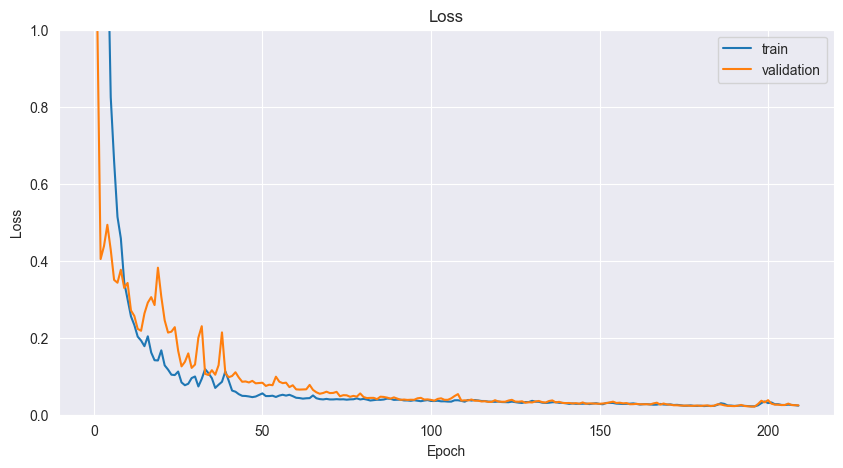

In [16]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='train')
plt.plot(history['valid_mse'],label='validation')
plt.ylim(0,1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()